Tải bộ dữ liệu WELFake

In [1]:
!gdown 1CgDGe1t2_SUVw9VvzOpMeRNfIvdHsjY3

Downloading...
From (original): https://drive.google.com/uc?id=1CgDGe1t2_SUVw9VvzOpMeRNfIvdHsjY3
From (redirected): https://drive.google.com/uc?id=1CgDGe1t2_SUVw9VvzOpMeRNfIvdHsjY3&confirm=t&uuid=f99e998f-b24d-42aa-ad13-540a30afe9b8
To: /content/WELFake_Dataset.csv
100% 245M/245M [00:03<00:00, 71.4MB/s]


In [2]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import pandas as pd
import re
import nltk

Xóa các kí tự null và nối cột title vào cột test

In [3]:
df = pd.read_csv("/content/WELFake_Dataset.csv")
df.dropna(subset = ['text', 'title'], inplace = True)
df['text'] = df['title'] + ' ' + df['text']

In [4]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

Thực hiện tăng cường dữ liệu xóa các từ không cần thiết (FWD)

In [5]:
import re
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()
corpus = []

def replace_synonyms(text):
    words = word_tokenize(text)
    replaced_text = []

    for word in words:
        synonyms = wordnet.synsets(word)
        if synonyms:
            synonym = synonyms[0].lemmas()[0].name()
            replaced_text.append(synonym.replace('_', ' '))
        else:
            replaced_text.append(word)

    return ' '.join(replaced_text)

def remove_function_words(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_text = [word for word in words if word.lower() not in stop_words]

    return ' '.join(filtered_text)

def preprocess_txt(text, use_synonyms=False, use_fwd=False):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    if use_synonyms:
        text = replace_synonyms(text)

    if use_fwd:
        text = remove_function_words(text)

    tokens = word_tokenize(text)

    # Stemming
    tokens = [stemmer.stem(token) for token in tokens]
    unique_tokens = []
    for token in tokens:
        if token not in unique_tokens:
            unique_tokens.append(token)

    preprocessed_text = ' '.join(unique_tokens)
    corpus.append(preprocessed_text)
    return preprocessed_text

df['preprocessed_text'] = df['text'].apply(lambda x: preprocess_txt(x, use_synonyms=False, use_fwd=True) if isinstance(x, str) else "")

In [6]:
df.head()

,Unnamed: 0,title,text,label,preprocessed_text
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,1,law enforc high alert follow threat cop white ...
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,1,unbeliev obama attorney gener say charlott rio...
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...","Bobby Jindal, raised Hindu, uses story of Chri...",0,bobbi jindal rais hindu use stori christian co...
4,4,SATAN 2: Russia unvelis an image of its terrif...,SATAN 2: Russia unvelis an image of its terrif...,1,satan russia unv imag terrifi new supernuk wes...
5,5,About Time! Christian Group Sues Amazon and SP...,About Time! Christian Group Sues Amazon and SP...,1,time christian group sue amazon splc design ha...


In [7]:
train_d, val_d, train_labels, val_labels = train_test_split(df['preprocessed_text'],df['label'],test_size=0.2,random_state=42)

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_length = 64

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Tokenize data

In [9]:
train_encodings = tokenizer(list(train_d), padding=True, truncation=True, max_length=max_length, return_tensors="tf")
val_encodings = tokenizer(list(val_d), padding=True, truncation=True, max_length=max_length, return_tensors="tf")

In [10]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
import tensorflow as tf
from transformers import TFBertForSequenceClassification, BertTokenizer

Xây dựng mô hình

In [12]:
from transformers import create_optimizer

optimizer, lr_schedule = create_optimizer(
    init_lr=5e-6,  
    num_warmup_steps=0,  
    num_train_steps=1000  
)  

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [13]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109483778 (417.65 MB)
Trainable params: 109483778 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Huấn luyện mô hình 

In [14]:
import tensorflow as tf

train_labels = train_labels.astype(int).values 
val_labels = val_labels.astype(int).values   

train_labels = tf.cast(train_labels, dtype=tf.int32) 
val_labels = tf.cast(val_labels, dtype=tf.int32) 

history = model.fit(
    {'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask']},
    train_labels,
    validation_data=(
        {'input_ids': val_encodings['input_ids'], 'attention_mask': val_encodings['attention_mask']},
        val_labels
    ),
    batch_size=16,
    epochs=3
)

Epoch 1/3
3577/3577 [==============================] - 999s 265ms/step - loss: 0.2106 - accuracy: 0.9223 - val_loss: 0.1925 - val_accuracy: 0.9324
Epoch 2/3
3577/3577 [==============================] - 963s 269ms/step - loss: 0.1845 - accuracy: 0.9349 - val_loss: 0.1925 - val_accuracy: 0.9324
Epoch 3/3
3577/3577 [==============================] - 956s 267ms/step - loss: 0.1849 - accuracy: 0.9355 - val_loss: 0.1925 - val_accuracy: 0.9324


Vẽ đồ thị học accuracy và loss

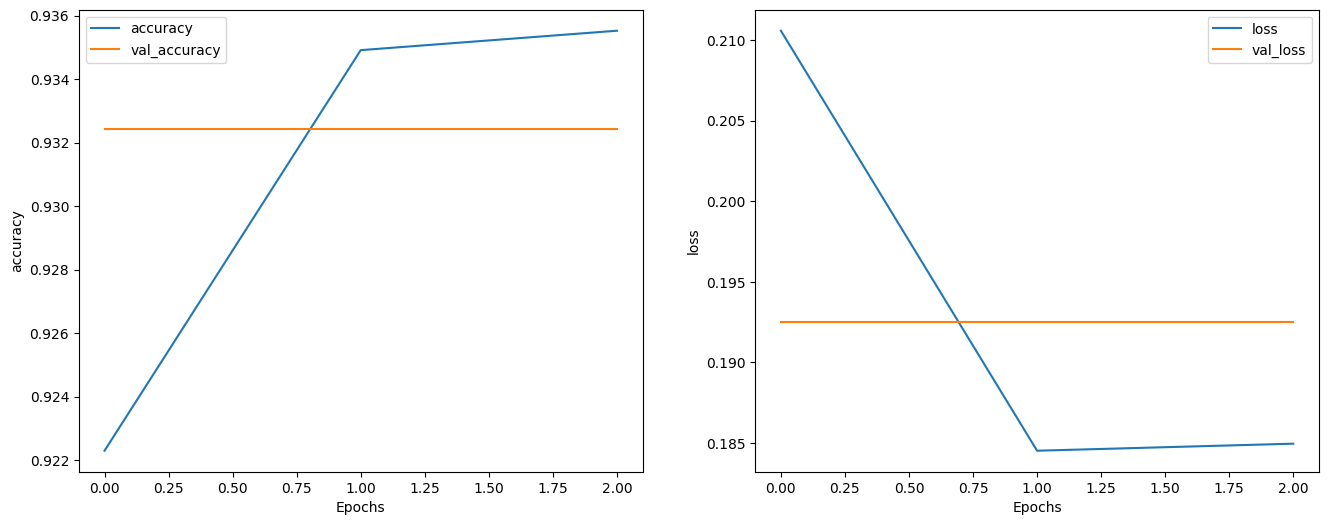

In [15]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):

    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])


plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

Đánh giá mô hình

In [16]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import numpy as np
import tensorflow as tf

y_pred_probs = model.predict({'input_ids': val_encodings['input_ids'], 'attention_mask': val_encodings['attention_mask']})
y_pred = np.argmax(y_pred_probs.logits, axis=1)


y_test = val_labels.numpy()  

print(classification_report(y_test, y_pred))



448/448 [==============================] - 72s 153ms/step
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      7081
           1       0.92      0.95      0.93      7227

    accuracy                           0.93     14308
   macro avg       0.93      0.93      0.93     14308
weighted avg       0.93      0.93      0.93     14308



Vẽ ma trận nhầm lẫn 

Text(70.72222222222221, 0.5, 'Real Labels')

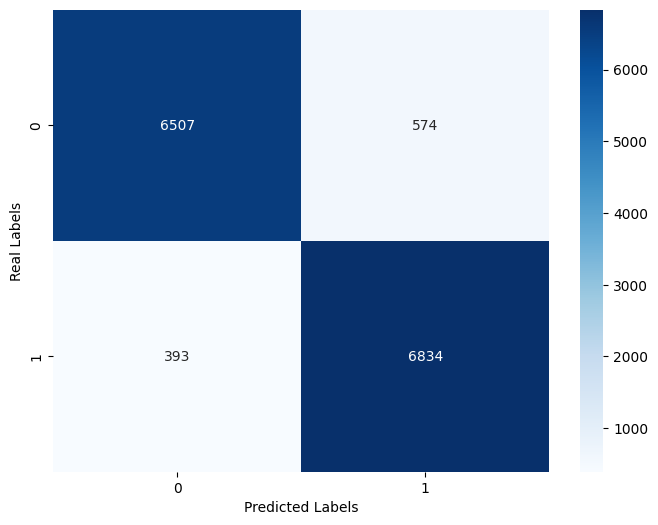

In [17]:
import seaborn as sns

plt.figure(figsize = (8,6))
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True,
            fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

conf_matrix = confusion_matrix(y_test,y_pred)

true_negatives = conf_matrix[0][0]
false_positives = conf_matrix[0][1]
false_negatives = conf_matrix[1][0]
true_positives = conf_matrix[1][1]

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f1 = 2 * (precision * recall) / (precision + recall)
accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')

Precision: 0.9225
Recall: 0.9456
F1-score: 0.9339
Accuracy: 0.9324
